# Model testing

## import modules and merge data

In [1]:

import sys
import pandas as pd              # python package for dataframes
import os                        # used to change directory paths
import matplotlib.pyplot as plt  # python package for plotting
import numpy as np
import seaborn as sns #package for plotting
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, HTML  # Make tables pretty
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#import sklearn.cross_validation.Bootstrap as bootstrap
import scipy
import zipfile
import gzip

#no need to open here
#with gzip.open('\\\\cskma0294\\F\\Evaluations\\JobPath\\WeeklyStatus_flags2018-12-28.gz') as f:
#    df= pd.read_csv(f).iloc[:,1:] # drop 1st column (an artefact of the zipping process)
                            
#df.head()

In [2]:
path_data = "\\\cskma0294\\F\\Evaluations\\JobPath"
os.chdir(path_data)

#df = pd.read_csv('Dec2015_anonx.csv', parse_dates = ['StartDate', 'EndDate', 'dob'])
# %% [markdown]
# ## Import outcomes dataset and tidy up

# %%
df = pd.read_csv("jp_outcomes.csv")


In [3]:

# Convert floats to ints to make reporting easier
numerics = ["float64"]
for col in df.select_dtypes(include=numerics).columns:
    if df[col].isnull().sum() == 0:
        # print(col)
        df[col] = df[col].astype("int")
# for col in df.columns:
#     print(col)


In [4]:
path_data = "\\\cskma0294\\F\\Evaluations\\JobPath\\Quarterly_status"
os.chdir(path_data)

#df = pd.read_csv('Dec2015_anonx.csv', parse_dates = ['StartDate', 'EndDate', 'dob'])
# %% [markdown]
# ## Import outcomes dataset and tidy up

# %%
df_shares = pd.read_csv("shares_2017.zip")
df2=pd.merge(df, df_shares, on='ppsn', how='left')

In [5]:
# Tidy up T and C columns to make processing easier
periods = []
for i in range(1, 9):
    this_period = 'period_'+str(i)
    df2[this_period] = df2['Group'+str(i)].str[:1]
    periods.append(this_period)

# Eliminate earlier T people from later period C
for i in range(1, 9):
    for j in range(i+1, 9):
        df2['period_'+str(j)].loc[df2['period_'+str(i)] == 'T'] = 0

# %% [markdown]
# ## Look - a group triangle!



C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:

ys=[]
for i in range(1,9):
    this_period = 'period_'+str(i)
    this_y='y_'+str(i)
    df2[this_y] = df2[this_period].replace(['T', 'C', '0'],[1, 0, np.NaN])
    ys.append(this_y)


In [41]:
df2['y_1'].value_counts()


0.0    88767
1.0     5581
Name: y_1, dtype: int64

In [42]:
df2.head()

,Unnamed: 0,id,ppsn,cluster,age,duration_days_0,sex,LM_code_rank_P1,occupation_rank_P1,ada_code_rank_P1,...,period_7,period_8,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8
0,0,0,0099665M,2,54,6316,1,6,2.0,5,...,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0206477C,2,59,3964,2,6,5.0,5,...,C,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,0202920T,2,59,1285,2,6,7.0,4,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,0205276K,5,55,1415,2,6,2.0,6,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,0202425J,2,59,2445,2,6,7.0,5,...,C,C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Select features

In [43]:
#features =['sw_pay_mean_1315', 'earn_tot_mean_1315', 'age', 'occupation_rank_P1','Duration Bands', 'cluster', 
#  'family_flag_rank_P1', 'WSW_13_15share', 'Ed_or_Training_13_15share', 'LM_WSW_13_15share']
features =['sw_pay_mean_1315', 
           'earn_tot_mean_1315', 
           'age', 
           'occupation_rank_P1',
          'Duration Bands',
           #'LM_code_rank_P1',
          #'LM_WSW_13_15share',
           #'family_flag_rank_P1',
           #'LM_WSW_13_15share',
           #'hist_lr_0',
           #'total_duration_days',
           # 'Duration Bands',
           #'Empl_13_15share',
            #'Empl_13_15sum',
 'Ed_or_Training_13_15share',
 #'Ed_or_Training_13_15sum',
 'LM_WSW_13_15share',
 #'LM_WSW_13_15sum',
 #'LR_13_15share',
 #'LR_13_15sum',
 'WSW_13_15share',
 #'WSW_13_15sum',
           #'Ed_or_Training_13_15share',
          ]

df = df2[features] # to enforce column order
df['y']=df2['y_1']
#y=['y_1']


C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
df['y'].value_counts()

0.0    88767
1.0     5581
Name: y, dtype: int64

In [45]:

df=df.dropna()
list(df)


['sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y']

In [46]:
y=df['y'].values
X=df.drop('y', axis='columns').values

In [47]:
X.shape

(91352, 8)

## train test split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=21, stratify=y)

## Testing K-nearest neighbours

In [62]:
knn = KNeighborsClassifier(n_neighbors=3)

In [19]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [20]:
y_pred = knn.predict(X_test)

In [21]:
print(knn.score(X_test, y_test))

0.930762704907


In [22]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[33980   370]
 [ 2160    31]]
             precision    recall  f1-score   support

        0.0       0.94      0.99      0.96     34350
        1.0       0.08      0.01      0.02      2191

avg / total       0.89      0.93      0.91     36541



0.940039955119


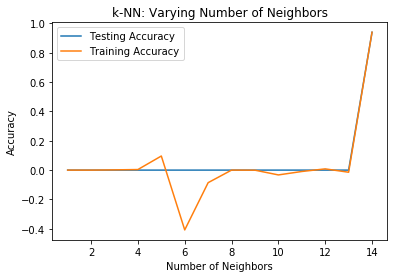

In [64]:
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn =KNeighborsClassifier(n_neighbors=i)

    # Fit the classifier to the training data
knn.fit(X_train, y_train)
   
    #Compute accuracy on the training set
train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
test_accuracy[i] = knn.score(X_test, y_test)
print(test_accuracy[i])    

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

## Testing Logistic regression

In [81]:
logreg = LogisticRegression()

In [82]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
y_pred = logreg.predict(X_test)

##### redirect to save images

In [64]:
path_data = "\\\cskma0294\\F\\Evaluations\\JobPath\\Python\\Analysis\\ModellingTreatment\\Images"
os.chdir(path_data)


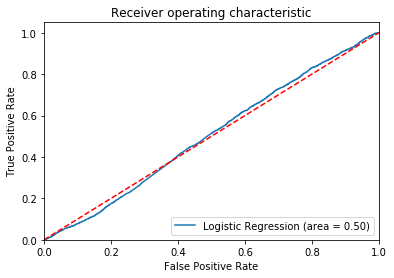

In [84]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [85]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.50400910461694126

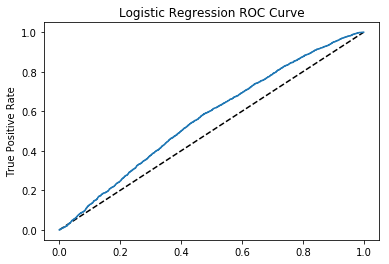

In [17]:




y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
#plt.xlabel('False Positive Rate’)
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
#plt.savefig("reg2.png", format='png', dpi=100,  bbox_inches='tight')
plt.show();

## Testing Lasso

In [30]:
lasso = Lasso(alpha=0.1, normalize=True)

In [31]:
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)


In [32]:
print(lasso.score(X_test, y_test))

-1.65872870994e-09


Feature selection using lasso

In [33]:
names = df.drop('y', axis=1).columns

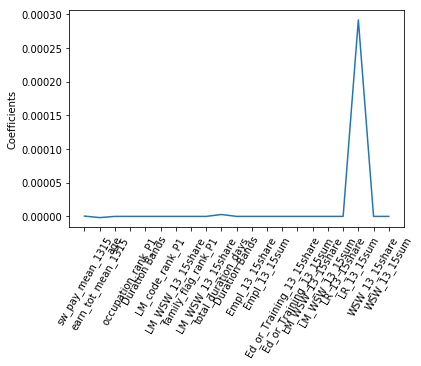

In [34]:
lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X, y).coef_
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names, rotation=60)
_ = plt.ylabel('Coefficients')
plt.show()

In [36]:
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score )
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)


training score: 0.00388729409025
test score:  0.00351551641266
number of features used:  4


In [42]:
lasso009 = Lasso(alpha=0.9, max_iter=10e5)
lasso009.fit(X_train,y_train)
train_score009=lasso009.score(X_train,y_train)
test_score009=lasso002.score(X_test,y_test)
coeff_used009 = np.sum(lasso009.coef_!=0)
print ("training score for alpha=0.09:", train_score009 )
print ("test score for alpha =0.09: ", test_score009)
print ("number of features used: for alpha =0.09:", coeff_used009)

training score for alpha=0.09: 0.00202130572888
test score for alpha =0.09:  0.00479898670286
number of features used: for alpha =0.09: 3


In [39]:
lasso002 = Lasso(alpha=0.02, max_iter=10e5)
lasso002.fit(X_train,y_train)
train_score002=lasso002.score(X_train,y_train)
test_score002=lasso002.score(X_test,y_test)
coeff_used002 = np.sum(lasso002.coef_!=0)
print ("training score for alpha=0.02:", train_score002 )
print ("test score for alpha =0.02: ", test_score002)
print ("number of features used: for alpha =0.02:", coeff_used002)

training score for alpha=0.02: 0.00550527814745
test score for alpha =0.02:  0.00479898670286
number of features used: for alpha =0.02: 6


In [40]:
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print ("training score for alpha=0.0001:", train_score00001 )
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)


training score for alpha=0.0001: 0.00583970262363
test score for alpha =0.0001:  0.00507264613939
number of features used: for alpha =0.0001: 12


In [41]:
lasso000001 = Lasso(alpha=0.00001, max_iter=10e5)
lasso000001.fit(X_train,y_train)
train_score000001=lasso000001.score(X_train,y_train)
test_score000001=lasso000001.score(X_test,y_test)
coeff_used000001 = np.sum(lasso000001.coef_!=0)
print ("training score for alpha=0.00001:", train_score000001 )
print ("test score for alpha =0.00001: ", test_score000001)
print ("number of features used: for alpha =0.00001:", coeff_used000001)

training score for alpha=0.00001: 0.0058417218196
test score for alpha =0.00001:  0.00506779700771
number of features used: for alpha =0.00001: 14


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


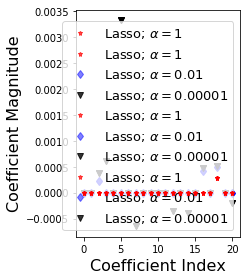

In [46]:






# lr = LinearRegression()
# lr.fit(X_train,y_train)
# lr_train_score=lr.score(X_train,y_train)
# lr_test_score=lr.score(X_test,y_test)
# print "LR training score:", lr_train_score 
# print "LR test score: ", lr_test_score
# plt.subplot(1,2,1)
# plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
# plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

#plt.xlabel('Coefficient Index',fontsize=16)
#plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso002.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
#plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()


## Testing Random forest

In [73]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,
                              n_estimators=100)
rfr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [75]:
print(rfr.feature_importances_)
print(rfr.predict([[0, 0, 0, 0,0,0,0,0]]))
print(rfr.score(X, y))

[2.72352759e-03 8.89264332e-02 2.27497034e-01 0.00000000e+00
 5.56052845e-03 6.28554935e-03 6.68362560e-01 6.44367726e-04]
[0.0499274]
0.0036719117857808565


## Hyperparameter tuning

#### For logistic

In [18]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}


In [19]:
logreg= LogisticRegression()

logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

logreg_cv.fit(X,y)


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   8.48343e-05,   7.19686e-04,   6.10540e-03,
         5.17947e-02,   4.39397e-01,   3.72759e+00,   3.16228e+01,
         2.68270e+02,   2.27585e+03,   1.93070e+04,   1.63789e+05,
         1.38950e+06,   1.17877e+07,   1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
start=datetime.now()

cv_results=cross_val_score(logreg, X, y, cv=9)
print(cv_results)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 

print("Best score is {}".format(logreg_cv.best_score_))

print (datetime.now()-start)


[ 0.94000591  0.94000591  0.94000591  0.94000591  0.94000591  0.94
  0.94009262  0.94009262  0.94009262]
Tuned Logistic Regression Parameters: {'C': 1.0000000000000001e-05}
Best score is 0.9400341536036431
0:00:06.389561


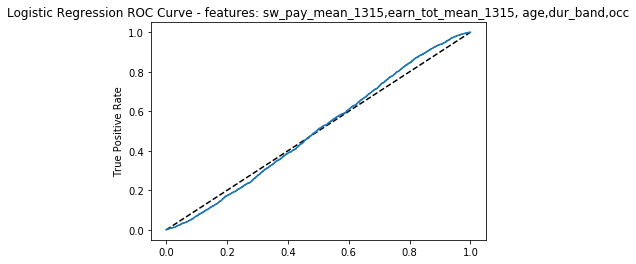

In [21]:

y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
#plt.xlabel('False Positive Rate’)
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve - features: sw_pay_mean_1315,earn_tot_mean_1315, age,dur_band,occ')
#plt.savefig("reg2.png", format='png', dpi=100,  bbox_inches='tight')
plt.show();

In [22]:
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_prob)

0.50280376849318076

#### Hyper - KNN

In [57]:
param_grid = {'n_neighbors': np.arange(1, 14)}

In [58]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)

start=datetime.now()
knn_cv.fit(X, y)

print (datetime.now()-start)

0:06:13.601768


In [59]:
print(knn_cv.best_params_)
print(knn_cv.best_score_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


{'n_neighbors': 12}
0.940034153604
[[34350     0]
 [ 2191     0]]
             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97     34350
        1.0       0.00      0.00      0.00      2191

avg / total       0.88      0.94      0.91     36541



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}


# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.005065086889448178
Tuned ElasticNet MSE: 0.056079345097482


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Sensitivity

## graphical output reproduced

In [71]:
df['earn_tot_mean_1315'].plot(type=barh bin=100)
plt.show()

SyntaxError: invalid syntax (<ipython-input-71-0272121f4aba>, line 1)

In [38]:
df['Duration Bands'].plot
plt.show()

## Conclusion

  fit a logistic regression model and output predicted probabilities of y

In [48]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X, y)

C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [49]:
y_pred = logreg.predict(X)
y_pred_prob = logreg.predict_proba(X)[:,1]
print(y_pred_prob)
type(y_pred_prob)

[0.55769412 0.58541041 0.58757211 ... 0.57025883 0.42179027 0.58768394]


numpy.ndarray

convert the ndarray into a dataframe and add that one column dataframe to the df dataframe

In [50]:
df['Propensity'] = pd.Series(y_pred_prob)


In [51]:
df.shape

(91352, 10)

#### retain the intial values of propensity, by treatment and control, to show what weighting has done

In [55]:
initial=df[['Propensity','y']]

In [56]:
initial.head()

,Propensity,y
0,0.557694,0.0
1,0.585410,0.0
2,0.587572,0.0
4,0.534520,0.0
5,0.396501,0.0


In [15]:
df['Propensity'].describe()

count    7.600900e+04
mean     4.912774e-01
std      7.807692e-02
min      2.280536e-08
25%      4.655022e-01
50%      5.108583e-01
75%      5.446194e-01
max      5.968602e-01
Name: Propensity, dtype: float64

In [113]:
initial_y0=initial.loc[initial['y']==0]
df_y1 = df.loc[df['y']==1]
df_y0 = w_df.loc[w_df['y']==0]

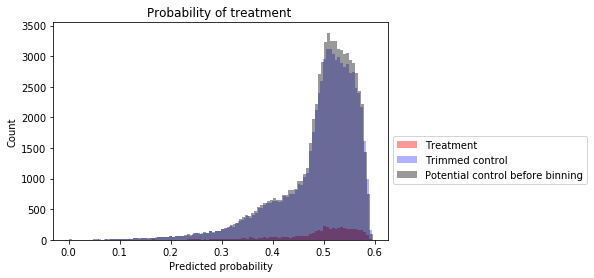

In [115]:
%matplotlib inline
fig = plt.figure()
ax = df_y1['Propensity'].hist(bins=100, alpha = 0.4, label = 'Treatment', color= 'red');
df_y0['Propensity'].hist(bins=100, alpha = 0.3, label = 'Trimmed control', color = 'blue');
initial_y0['Propensity'].hist(bins=100, alpha = 0.4, label = 'Potential control before binning', color ='black');

#%matplotlib inline
plt.legend(bbox_to_anchor=(1, 0.5))
plt.title('Probability of treatment ')
ax.grid(False)
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.show()


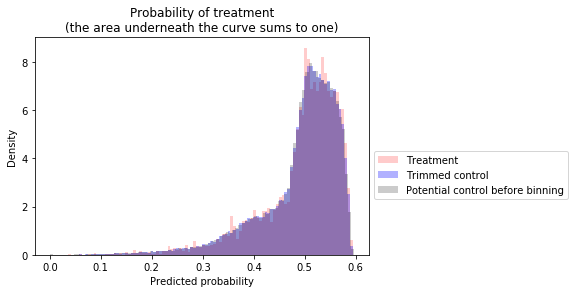

In [119]:

%matplotlib inline
fig = plt.figure()
ax = df_y1['Propensity'].hist(bins=100, alpha = 0.2, label = 'Treatment', color= 'red', density=True);
df_y0['Propensity'].hist(bins=100, alpha = 0.3, label = 'Trimmed control', color = 'blue', density=True);
initial_y0['Propensity'].hist(bins=100, alpha = 0.2, label = 'Potential control before binning', color ='black', density=True);

#%matplotlib inline
plt.legend(bbox_to_anchor=(1, 0.5))
plt.title('Probability of treatment\n' '(the area underneath the curve sums to one)')
ax.grid(False)
plt.xlabel('Predicted probability')
plt.ylabel('Density')
plt.show()



calculate inverse probability weights - note the separate columns for c and t. Better to do the c calculation conditional on y_1  being 0, and then weight is 1 if y_1 is 1

In [38]:

#if y_1=1 then ipw= 1/0 + (1-1)/(1-0)
#if y_1=0 then ipw= 0/'0' + (1-0)/(1-'0')

#final['iptw_t']=1/0+(1-1)/(1-0)
final['iptw_c']= 0/final['Propensity'] + (1-0)/(1-final['Propensity'])
final['iptw_t']= 1

#final['iptw'] = np.where(final['iptw_c']!=NaN, final['iptw_c'], 'no')


In [37]:
list(df)
#df['y'].unique()

['id',
 'sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y',
 'Propensity']

 unsuccessful attempt to either show graphically the distribution of scores by y, or groupby y to calculate means

In [16]:
df=df.reset_index()
df=df.rename(columns={'index': 'id'})


In [108]:
df.groupby("y")["Propensity"].unique()

y
0.0    [0.5576941196015129, 0.5854104112000227, 0.587...
1.0    [0.49741992170863886, 0.5524188318090787, 0.43...
Name: Propensity, dtype: object

In [109]:
# %%
def add_weights(df, period):
    # 1. Create scores
    # Currently done above with global ranks but need to replace

    # 2. Create bins based on scores
    # Create a temporary df for T and C groups
    df_T = df.loc[df[period] == 1].copy()
    df_C = df.loc[df[period] == 0].copy()
        # Split T group into equal sized bins
    
    df_T["bin"], bins = pd.qcut(df_T["Propensity"], 100, retbins=True, labels=False)

    # Put C group into T bins based on T bin edges
    #df_T["bin"]=df_T["bin"].astype('int')
    #print(df_T[df_T["bin"].isna()])
    print(df_T["bin"].isnull().count())
    df_T["bin"]=df_T["bin"].astype('category')
    df_C["bin"] = pd.cut(df_C["Propensity"], bins, labels=range(len(bins) - 1))
    df_C["bin"]=df_C["bin"].cat.add_categories([999])
    df_T["bin"]=df_T["bin"].cat.add_categories([999])
    print(df_C.groupby("bin").count())

    
    #df_C["bin"]=df_C["bin"].fillna(999)
    # Exclude unassigned C group members to eliminate outliers
    df_C = df_C.dropna(subset=["bin"])
    df_C["bin"] = df_C["bin"].astype("int")
    print(f"Size of T dataframe, {df_T.shape}")
    print(df_C.shape)
    print(df.shape)

    # 3. Add weights based on bins
    # Create counts for T and C by bin
    t_bin_counts = pd.Series(df_T.groupby("bin")["Propensity"].count(), name="t_bin_counts")
    c_bin_counts = pd.Series(df_C.groupby("bin")["Propensity"].count(), name="c_bin_counts")
    bin_counts = pd.concat([t_bin_counts, c_bin_counts], axis="columns")

    # Divide T by C to get weights for C group
    bin_counts["abs_weight"] = bin_counts["t_bin_counts"] / bin_counts["c_bin_counts"]
    c_total = df_C.shape[0]
    t_total = df_T.shape[0]
    bin_counts["weight"] = bin_counts["abs_weight"] * c_total / t_total

    # All Ts have weight = 1
    df_T["weight"] = 1
    df_T["abs_weight"] = 1

    # Assign C weights based on weights in bin_counts dataframe
    # Have to reset and then set index to avoid losing it!
    df_C = df_C.reset_index()
    df_C = df_C.merge(bin_counts, how="left", left_on="bin", right_index=True )
    df_C = df_C.set_index("id")

#     # Append T and C dataframes together
    out_df = df_T.append(df_C)
   #out_df = out_df[["weight", "abs_weight", 'bin']]
    
    return out_df

# %%

w_df = add_weights(df, 'y')


5478
     sw_pay_mean_1315  earn_tot_mean_1315  age  occupation_rank_P1  \
bin                                                                  
0                 777                 777  777                 777   
1                 693                 693  693                 693   
2                 613                 613  613                 613   
3                 838                 838  838                 838   
4                 876                 876  876                 876   
5                 655                 655  655                 655   
6                 599                 599  599                 599   
7                 688                 688  688                 688   
8                 927                 927  927                 927   
9                 649                 649  649                 649   
10                673                 673  673                 673   
11                770                 770  770                 770   
12             

Size of T dataframe, (5478, 11)
(71290, 11)
(91352, 10)


KeyError: 'id'

In [110]:
w_df.shape

(76768, 17)

In [111]:
w_df.head()

,Duration Bands,Ed_or_Training_13_15share,LM_WSW_13_15share,Propensity,WSW_13_15share,abs_weight,age,bin,c_bin_counts,earn_tot_mean_1315,id,index,occupation_rank_P1,sw_pay_mean_1315,t_bin_counts,weight,y
13,1,0.0,0.978,0.497420,0.0,1.0,55,38.0,NaN,3267,15.0,NaN,6.0,6299,NaN,1.0,1.0
44,2,0.0,0.890,0.552419,0.0,1.0,30,79.0,NaN,0,52.0,NaN,5.0,17865,NaN,1.0,1.0
47,0,0.0,0.505,0.431061,0.0,1.0,30,17.0,NaN,2762,55.0,NaN,3.0,1472,NaN,1.0,1.0
85,1,0.0,0.978,0.399625,0.0,1.0,42,12.0,NaN,3704,99.0,NaN,6.0,12173,NaN,1.0,1.0
92,0,0.0,0.440,0.551716,0.0,1.0,40,78.0,NaN,4669,109.0,NaN,9.0,6845,NaN,1.0,1.0


[0. 1.]
(85874, 11)
(5478, 11)


C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


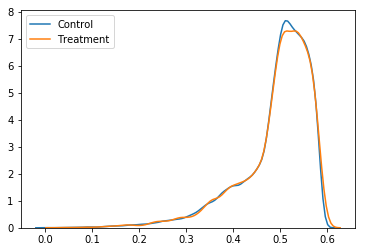

In [23]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

# # Sort the dataframe by target
# # Use a list comprehension to create list of sliced dataframes
targets = [df.loc[df['y'] == val] for val in unique_vals]
for index, group in enumerate(['Control', 'Treatment']):
    subset=df.loc[df['y'] ==index]
    print(subset.shape)
    sns.kdeplot(subset['Propensity'], kernel='gau', label = group )
plt.legend()
plt.show()

the code above may have assigned the inverse probability weights to iptw when iptw_c was not 1 and otherwise inserted iptw_t

In [30]:
print(df['Propensity'].groupby(df['y']).median())

y
0.0    0.510817
1.0    0.511462
Name: Propensity, dtype: float64


[ 0.  1.]
(85874, 12)
(5478, 12)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


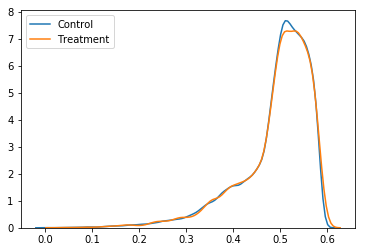

In [147]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

# # Sort the dataframe by target
# # Use a list comprehension to create list of sliced dataframes
targets = [df.loc[df['y'] == val] for val in unique_vals]
for index, group in enumerate(['Control', 'Treatment']):
    subset=df.loc[df['y'] ==index]
    print(subset.shape)
    sns.kdeplot(subset['Propensity'], kernel='gau', label = group )
plt.legend()
plt.show()

[0. 1.]


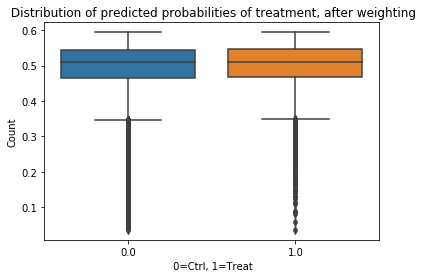

In [125]:

unique_vals = df['y'].unique()
print(unique_vals)
df['y'].value_counts()

sns.boxplot(x="y", y='Propensity', data=w_df )
plt.title(' Distribution of predicted probabilities of treatment, after weighting')

#plt.legend()
plt.xlabel(' 0=Ctrl, 1=Treat')
plt.ylabel('Count')

plt.show()

[0. 1.]


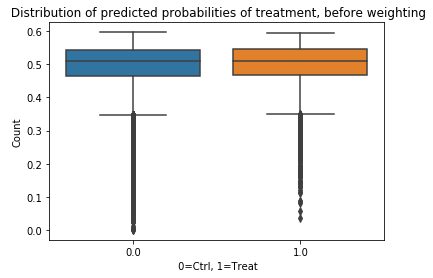

In [126]:

unique_vals = initial['y'].unique()
print(unique_vals)
initial['y'].value_counts()

sns.boxplot(x="y", y='Propensity', data=initial )
plt.title(' Distribution of predicted probabilities of treatment, before weighting')
#plt.legend()
plt.xlabel(' 0=Ctrl, 1=Treat')
plt.ylabel('Count')
plt.show()

In [63]:

print(initial['Propensity'].groupby(initial['y']).describe())

       count      mean       std           min       25%       50%       75%  \
y                                                                              
0.0  71346.0  0.491188  0.078090  2.280536e-08  0.465416  0.510817  0.544502   
1.0   4663.0  0.492648  0.077878  3.561841e-02  0.466843  0.511462  0.545467   

          max  
y              
0.0  0.596860  
1.0  0.594159  


In [62]:
print(initial.shape)

(91352, 2)


In [ ]:
 #select the important variables and demonstrate how weights (analogous to scaling here) have transformed the data
    #weighted_df['x2'] replaces scaled_df['x2']  
    
#Use StandardScaler
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])
# Plot and visualize
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['x1'], ax=ax1)
sns.kdeplot(df['x2'], ax=ax1)
sns.kdeplot(df['x3'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['x1'], ax=ax2)
sns.kdeplot(scaled_df['x2'], ax=ax2)
sns.kdeplot(scaled_df['x3'], ax=ax2)

plt.show()

In [ ]:
 #select the important variables and demonstrate how weights (analogous to scaling here) have transformed the data
    #weighted_df['x2'] replaces scaled_df['x2']  
    
#Use StandardScaler
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2', 'x3'])
# Plot and visualize
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df['x1'], ax=ax1)
sns.kdeplot(df['x2'], ax=ax1)
sns.kdeplot(df['x3'], ax=ax1)

ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['x1'], ax=ax2)
sns.kdeplot(scaled_df['x2'], ax=ax2)
sns.kdeplot(scaled_df['x3'], ax=ax2)

plt.show()

In [ ]:
 #select the important variables and demonstrate how weights (analogous to scaling above) have transformed the data
    #weighted_df['x2'] replaces scaled_df['x2']  
    


weighted_df = pd.DataFrame(weighted_df, columns=['sw_pay_mean_1315',  'earn_tot_mean_1315', 'age'])
# Plot and visualize
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before weighting')
sns.kdeplot(df['sw_pay_mean_1315'], ax=ax1)
sns.kdeplot(df['earn_tot_mean_1315'], ax=ax1)
sns.kdeplot(df['age'], ax=ax1)

ax2.set_title('After weighting')
sns.kdeplot(scaled_df['sw_pay_mean_1315'], ax=ax2)
sns.kdeplot(scaled_df['earn_tot_mean_1315'], ax=ax2)
sns.kdeplot(scaled_df['age'], ax=ax2)

plt.show()

#### Next, having assigned weights to the dataset, compare ...

#### absolute standardised differences 
for each of the baseline covariates inthe unweighted sample and in the sample weighted by weights derived from the specification of the propensity score model

 superimpose a line at 10% to indicat the limit of negligible imbalance

    calculate for weighted_df and df for the following variables:

sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y']
 
 split into four datasets to calculate std dev?

In [127]:
#df.groupby("y").std(ddof=0) 



print(df.groupby(['y'])['age'].apply(np.std))

print(df.groupby(['y'])['age'].apply(np.mean))

y
0.0    11.081577
1.0    10.796911
Name: age, dtype: float64
y
0.0    38.912663
1.0    40.424790
Name: age, dtype: float64


In [ ]:
# is it possible to loop through the columns in the dataframe and calculate a value for smd
# this needs to subtract mean values where y =0 from those where y=1; then add std dev values for both y groups and divide by two

for col in df.columns:
    df['smd']=df.groupby(['y']).apply(np.mean)/df.groupby(['y']).apply(np.std)
            # print(col)
    df[col] = df[col].astype("int")


In [ ]:
scipy.stats.zscore()



[treatment mean (age) - control mean (age)]/sq root (sample variance treatment + sample variance control)/2
for var in vars:
df(var).mean()/statistics.stdev(df(var))

df.loc[:,"age"].std()

sw_pay_mean_1315',
 'earn_tot_mean_1315',
 'age',
 'occupation_rank_P1',
 'Duration Bands',
 'Ed_or_Training_13_15share',
 'LM_WSW_13_15share',
 'WSW_13_15share',
 'y']

calculate mean difference for each variable and std dev, then
df
mean()
statistics.stdev(data)


df.groupby("y").std(ddof=0) 

[0. 1.]
(85874, 2)
(5478, 2)


C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\hughcronin\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


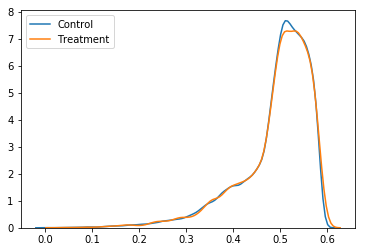

In [66]:

unique_vals = initial['y'].unique()
print(unique_vals)
initial['y'].value_counts()

# # Sort the dataframe by target
# # Use a list comprehension to create list of sliced dataframes
targets = [initial.loc[initial['y'] == val] for val in unique_vals]
for index, group in enumerate(['Control', 'Treatment']):
    subset=initial.loc[initial['y'] ==index]
    print(subset.shape)
    sns.kdeplot(subset['Propensity'], kernel='gau', label = group )
plt.legend()
plt.show()